In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
import swyft
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
sys.path.insert(0, "../submarine")
import simulator as sim
import data

from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel

In [14]:
simulator = sim.SubmarineSim(channels=2)

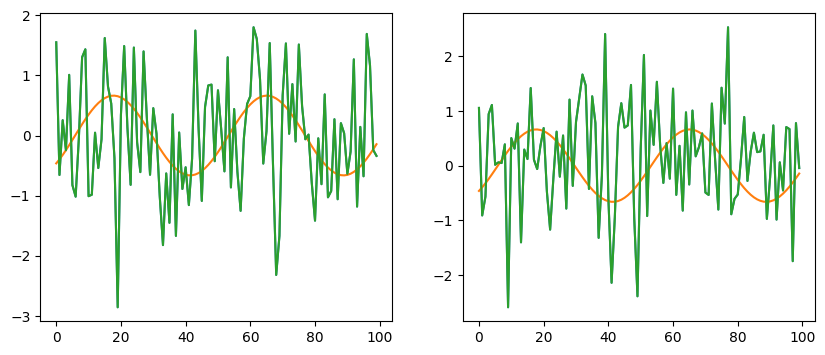

In [15]:
sample = simulator.sample()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(sample['noise'][0])
ax[0].plot(sample['signal'][0])
ax[0].plot(sample['data'][0])

ax[1].plot(sample['noise'][1])
ax[1].plot(sample['signal'][1])
ax[1].plot(sample['data'][1])

In [36]:
class Network(swyft.SwyftModule):
    def __init__(self, settings=None, sim=None):
        super().__init__()

        self.num_params = 1  # Inferring only xi
        self.npts = 100
        self.channels = 2
        self.num_feat_param = 2

        # Standardization layers for log and non-log data
        self.nl_channel1_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_channel2_nolog = OnlineStandardizingLayer(shape=(self.npts,))

        # Residual networks for log and non-log data
        self.resnet = ResidualNetWithChannel(
            channels=2,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        
        self.resnet_no_log = ResidualNetWithChannel(
            channels=2,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )

        # Log-ratio estimator for Bayesian inference
        self.log_ratio_estimator = swyft.LogRatioEstimator_Ndim(
            num_features=1 * self.num_feat_param * self.num_params,
            marginals=[(0,)],  # Inferring log-ratio for xi
            num_blocks=3,
            hidden_features=64,
            varnames="xi",
            dropout=0.1,
        )

    def forward(self, A, B):

        # Process non-log-transformed data
        no_log_data = A["data"].transpose(1, 2)  # Shape: (Batch, Freq, Channel)

        norm_channel1_nolog = self.nl_channel1_nolog(no_log_data[..., 0])  # Shape: (Batch, Freq)
        norm_channel2_nolog = self.nl_channel2_nolog(no_log_data[..., 1])  # Shape: (Batch, Freq)

        # Combine normalized non-log-transformed data
        no_log_full_data = torch.stack([norm_channel1_nolog, norm_channel2_nolog], dim=-2)  # Shape: (Batch, Channel, Freq)

        # Process lnon-log data through residual networks
        compression_no_log = self.resnet_no_log(no_log_full_data)  # Shape: (Batch, num_params * num_feat_param)

        # Concatenate the features from both representations
        s_no_log = compression_no_log.reshape(-1, self.num_params * self.num_feat_param)
        s_combined =  s_no_log

        # Compute log-ratio for Bayesian inference
        log_ratio = self.log_ratio_estimator(s_combined, B["xi"][:, :1])

        return log_ratio

In [ ]:
dm = data.OnTheFlyDataModule(simulator, Nsims_per_epoch=10000, batch_size=128)
trainer = swyft.SwyftTrainer(accelerator='cpu', max_epochs=30, enable_progress_bar=False)
network = Network()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
# #Assume you want to load from some checkpoint
# path = os.getcwd()
# to_add = '/lightning_logs/Andronikis_files/checkpoints/'
# filename = 'epoch=19-step=1100.ckpt'

# network_2d = Network.load_from_checkpoint(path + to_add + filename)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
The following callbacks returned in `LightningModule.confi

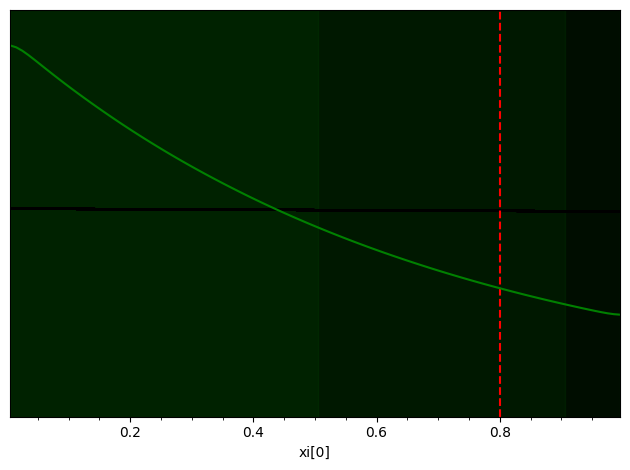

In [42]:
for idx in range(100):
    observation = simulator.sample(conditions={"xi": np.array([0.8])})
    prior_samples = swyft.Samples(
        xi=simulator.transform_samples(np.reshape(np.linspace(0.0, 1.0, 100), (-1, 1)))
    )
    predictions = trainer.infer(
        network, observation, prior_samples.get_dataloader(batch_size=2048)
    )
    if idx == 0:
        lrs_total = predictions
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0);
    else:
        lrs_total.logratios += predictions.logratios
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0, fig=plt.gcf());
plt.axvline(observation["xi"][0], color="red", linestyle="--")
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green', fig=plt.gcf());

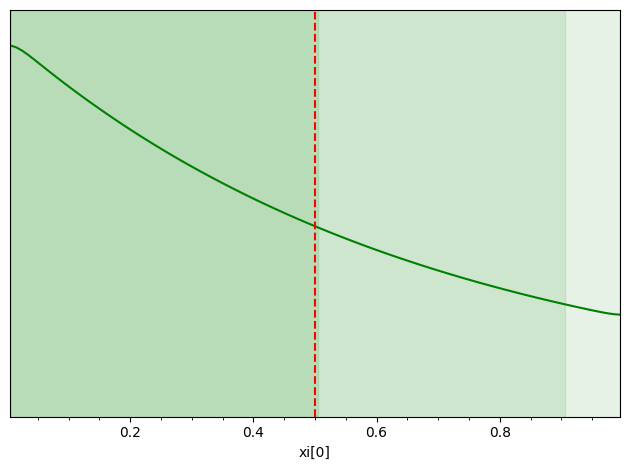

In [44]:
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green');
plt.axvline(0.5, color='red', linestyle='--')

In [106]:
class SubmarineStats:
    def __init__(self, simulator):
        self.simulator = simulator
    
    def log_likelihood(self, data, theta):
        mu = data - self.simulator.signal(theta)
        sigma = np.sqrt(self.simulator.psd)
        return -0.5 * np.sum(mu**2 / sigma**2) + np.sum(np.log(sigma))

In [107]:
test_data = simulator.sample(
    targets=["data"],
    conditions={"xi": np.array([1.0]), "theta": np.array([0.6, 0.0, 0.5])},
)

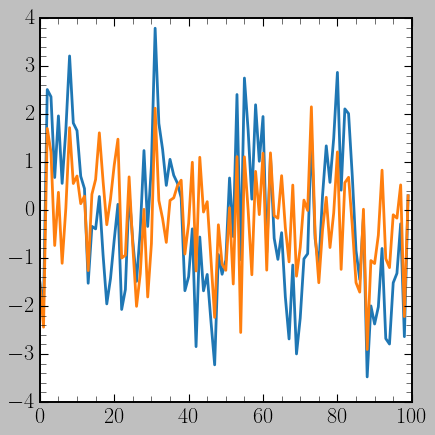

In [108]:
plt.plot(test_data['data'])
plt.plot(test_data['noise'])

100%|██████████| 1000/1000 [00:00<00:00, 18837.77it/s]


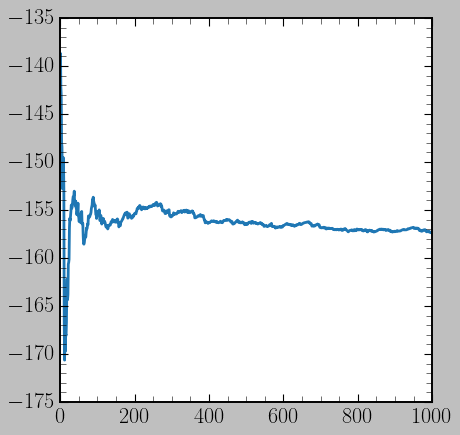

In [109]:
values = []
averages = []
stats_module = SubmarineStats(simulator)
for i in tqdm.tqdm(range(1000)):
    theta = simulator.sample(targets=["theta"])["theta"]
    value = stats_module.log_likelihood(test_data['data'], theta)
    values.append(value)
    averages.append(np.mean(values))
plt.plot(averages)

In [110]:
import dynesty
from dynesty import NestedSampler

# Define the log-likelihood function
def log_likelihood(theta):
    return stats_module.log_likelihood(test_data['data'], theta)

# Define the prior transform function
def prior_transform(utheta):
    # Assuming uniform priors for simplicity
    return utheta * 10  # Scale to the desired range

# Initialize the nested sampler
ndim = 3  # Number of parameters in theta
sampler = NestedSampler(log_likelihood, prior_transform, ndim)

# Run the nested sampler
sampler.run_nested()

# Extract the results
results = sampler.results

# Print the evidence (logZ)
print("Log-evidence: ", results.logz[-1])

1853it [00:00, 2131.85it/s, bound: 1 | nc: 3 | ncall: 18083 | eff(%): 10.247 | loglstar:   -inf < -125.944 <    inf | logz: -129.681 +/-  0.064 | dlogz: 36.681 >  0.509]/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2176it [00:02, 596.49it/s, bound: 10 | nc: 92 | ncall: 24327 | eff(%):  8.945 | loglstar:   -inf < -124.693 <    inf | logz: -129.021 +/-  0.071 | dlogz: 54.893 >  0.509]/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determin

Log-evidence:  -70.12683882096245
